In [1]:
#Importing all required packages
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns


import os
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import time

np.random.seed(42)
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Loading Dataset with relative path
ed = pd.read_csv('energydata_complete.csv')
ed

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [3]:
#Data Pre-Processing
def myPreProc(ed):
    procData = ed.dropna(how = 'all', axis = 1, inplace = False)
    procData = procData.dropna() 
    procData['Power'] = procData['Appliances'].astype(int) + procData['lights'].astype(int)
    procData = procData.drop('Appliances', axis = 1);
    procData = procData.drop('lights', axis = 1);
    procData = procData.drop('rv1', axis = 1);
    procData = procData.drop('rv2', axis = 1);
    procData = procData.drop('date', axis = 1);
    return procData
procData = myPreProc(ed)
procData.isna().sum();
procData

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Power
0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,...,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,90
1,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,...,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,90
2,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,...,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,80
3,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,...,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,90
4,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,...,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,...,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,100
19731,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,...,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,90
19732,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,...,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,280
19733,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,...,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,430


In [4]:
#Splitting of Data
X = procData.drop('Power', axis=1)
y = y=procData['Power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [5]:
#XGB Model Fitting
xgb_model = XGBRegressor()
P_xgb=xgb_model.fit(X_train,y_train)

<AxesSubplot: >

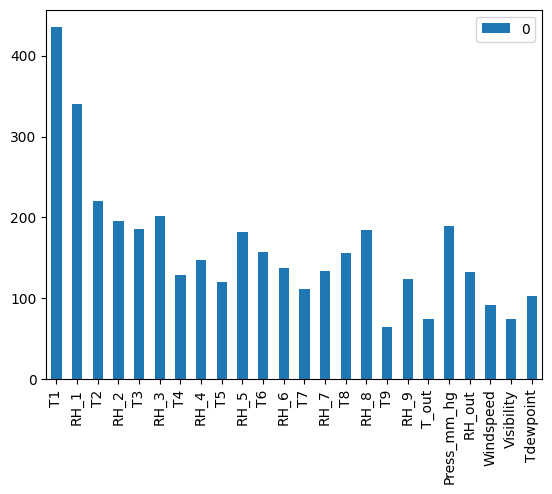

In [6]:
#Feature Importance
f_importance = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame.from_dict(data=f_importance, orient='index')
importance_df.plot.bar()

It is noticed that T_9, T_out, Visibility & Windspeed have lower feature importance scores for this specific model.
These will be removed as part of data processing going forward to improve the model's performance.

In [7]:
#Training Metrics
y_train_pred = xgb_model.predict(X_train)
print('The training R_square is: %.2f'% r2_score(y_train, y_train_pred))
print('The MAE is:%2.f'%mean_absolute_error(y_train, y_train_pred))
print('MSE is: %2.f'%mean_squared_error(y_train, y_train_pred))
print('The RMSE is: %2.f'% np.sqrt(mean_squared_error(y_train, y_train_pred)))

The training R_square is: 0.87
The MAE is:22
MSE is: 1423
The RMSE is: 38


In [8]:
#Testing Metrics
y_test_pred = xgb_model.predict(X_test)
print('The testing R_square is: %.2f'% r2_score(y_test, y_test_pred))
print('The MAE is:%2.f'%mean_absolute_error(y_test, y_test_pred))
print('MSE is: %2.f'%mean_squared_error(y_test, y_test_pred))
print('The RMSE is: %2.f'% np.sqrt(mean_squared_error(y_test, y_test_pred)))

The testing R_square is: 0.45
The MAE is:39
MSE is: 6112
The RMSE is: 78


In [9]:
#Dropping of columns after feature selection
procData2 = procData.drop('T9', axis = 1)
procData2 = procData2.drop('T_out', axis = 1)
procData2 = procData2.drop('Visibility', axis = 1)
procData2 = procData2.drop('Windspeed', axis = 1)
procData2

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Tdewpoint,Power
0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,...,84.256667,17.200000,41.626667,18.2000,48.900000,45.5300,733.5,92.000000,5.300000,90
1,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,...,84.063333,17.200000,41.560000,18.2000,48.863333,45.5600,733.6,92.000000,5.200000,90
2,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,...,83.156667,17.200000,41.433333,18.2000,48.730000,45.5000,733.7,92.000000,5.100000,80
3,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,...,83.423333,17.133333,41.290000,18.1000,48.590000,45.4000,733.8,92.000000,5.000000,90
4,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,...,84.893333,17.200000,41.230000,18.1000,48.590000,45.4000,733.9,92.000000,4.900000,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,...,1.000000,24.500000,44.500000,24.7000,50.074000,46.7900,755.2,55.666667,13.333333,100
19731,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,...,1.000000,24.557143,44.414286,24.7000,49.790000,46.7900,755.2,56.000000,13.300000,90
19732,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,...,1.000000,24.540000,44.400000,24.7000,49.660000,46.7900,755.2,56.333333,13.266667,280
19733,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,...,1.000000,24.500000,44.295714,24.6625,49.518750,46.8175,755.2,56.666667,13.233333,430


In [10]:
#Test Train Split and Standardization of newly processed data
X = procData2.drop('Power', axis=1)
y = procData2['Power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [11]:
# Fitting model for Standardised data
xgb_model_std = XGBRegressor()
P_xgb_std=xgb_model_std.fit(X_train_std,y_train)

In [12]:
#Standardised model's training metrics
y_train_pred_std = P_xgb_std.predict(X_train_std)
print('The training R_square is: %.2f'% r2_score(y_train, y_train_pred_std))
print('The MAE is:%2.f'%mean_absolute_error(y_train, y_train_pred_std))
print('MSE is: %2.f'%mean_squared_error(y_train, y_train_pred_std))
print('The RMSE is: %2.f'% np.sqrt(mean_squared_error(y_train, y_train_pred_std)))

The training R_square is: 0.85
The MAE is:23
MSE is: 1624
The RMSE is: 40


In [13]:
#Standardised model's testing metrics
y_test_pred_std = P_xgb_std.predict(X_test_std)
print('The testing R_square is: %.2f'% r2_score(y_test, y_test_pred_std))
print('The MAE is:%2.f'%mean_absolute_error(y_test, y_test_pred_std))
print('MSE is: %2.f'%mean_squared_error(y_test, y_test_pred_std))
print('The RMSE is: %2.f'% np.sqrt(mean_squared_error(y_test, y_test_pred_std)))

The testing R_square is: 0.49
The MAE is:38
MSE is: 5481
The RMSE is: 74


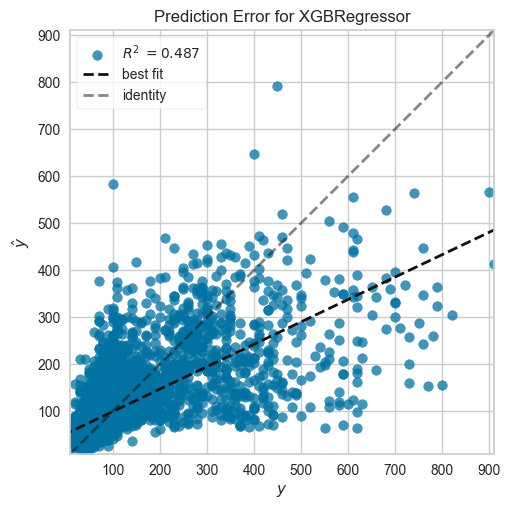

<AxesSubplot: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [14]:
# Plotting Prediction errors using Yellowbrick
from yellowbrick.regressor import PredictionError
visualiser = PredictionError(P_xgb_std)
visualiser.fit(X_train_std, y_train)
visualiser.score(X_test_std, y_test)
visualiser.poof()

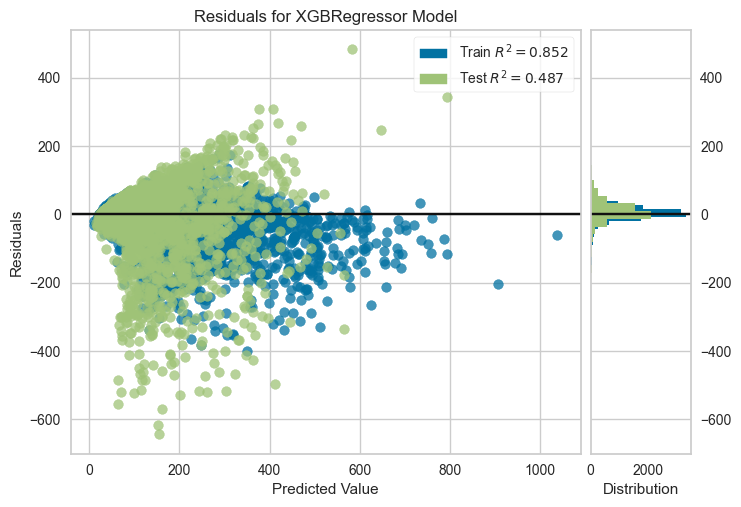

<AxesSubplot: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
from yellowbrick.regressor import ResidualsPlot
visualiser = ResidualsPlot(P_xgb_std)
visualiser.fit(X_train_std, y_train)
visualiser.score(X_test_std, y_test)
visualiser.poof()

In [16]:
#input possible best values for the grid
n_estimators = [30, 40]
max_depth = [9, 10]
learning_rate=[0.1, 0.05]
min_child_weight=[3, 4]

After multiple permutations of the possible values of the parameters the above values were found to give the best parameters without overfitting to the extreme.
It was noted that with increase in number of n_estimators and max_depth past the best parameter values the model tends to overfit.

Deafult values are as below.
Learning Rate 0.3;
min_child_weight = 1;
max_depth = 6;
n_estimators=100;

In [17]:
# Creating Parameter Grid
param_grid = {'n_estimators': n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate,
              'min_child_weight':min_child_weight}
print(param_grid)

{'n_estimators': [30, 40], 'max_depth': [9, 10], 'learning_rate': [0.1, 0.05], 'min_child_weight': [3, 4]}


In [18]:
#Hyperparameter Tuning with GridsearchCV to find best Parameters
grid_model = XGBRegressor()
xgb_Grid = GridSearchCV(estimator = grid_model, param_grid =param_grid, cv=10, verbose=0)
xgb_Grid.fit(X_train_std, y_train)
xgb_Grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 40}

In [19]:
#Standardised model's training metrics
y_train_pred_grid = xgb_Grid.predict(X_train_std)
print('The training R_square is: %.2f'% r2_score(y_train, y_train_pred_grid))
print('The MAE is:%2.f'%mean_absolute_error(y_train, y_train_pred_grid))
print('MSE is: %2.f'%mean_squared_error(y_train, y_train_pred_grid))
print('The RMSE is: %2.f'% np.sqrt(mean_squared_error(y_train, y_train_pred_grid)))

The training R_square is: 0.85
The MAE is:21
MSE is: 1686
The RMSE is: 41


In [20]:
#Standardised Grid model's testing metrics
y_test_pred_grid = xgb_Grid.predict(X_test_std)
print('The testing R_square is: %.2f'% r2_score(y_test, y_test_pred_grid))
print('The MAE is:%2.f'%mean_absolute_error(y_test, y_test_pred_grid))
print('MSE is: %2.f'%mean_squared_error(y_test, y_test_pred_grid))
print('The RMSE is: %2.f'% np.sqrt(mean_squared_error(y_test, y_test_pred_grid)))

The testing R_square is: 0.52
The MAE is:34
MSE is: 5105
The RMSE is: 71


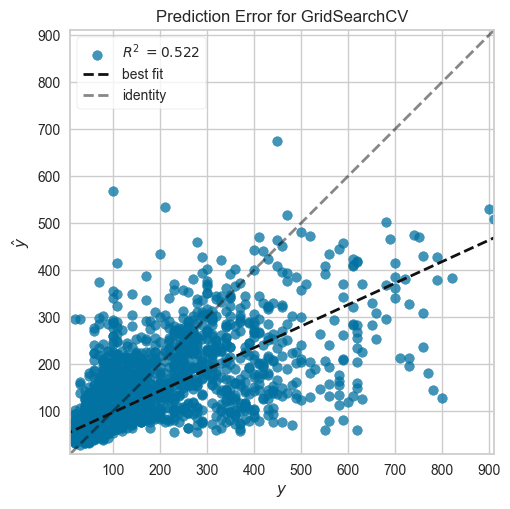

<AxesSubplot: title={'center': 'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [21]:
# Plotting Prediction errors using Yellowbrick
from yellowbrick.regressor import PredictionError
visualiser = PredictionError(xgb_Grid)
visualiser.fit(X_train_std, y_train)
visualiser.score(X_test_std, y_test)
visualiser.poof()

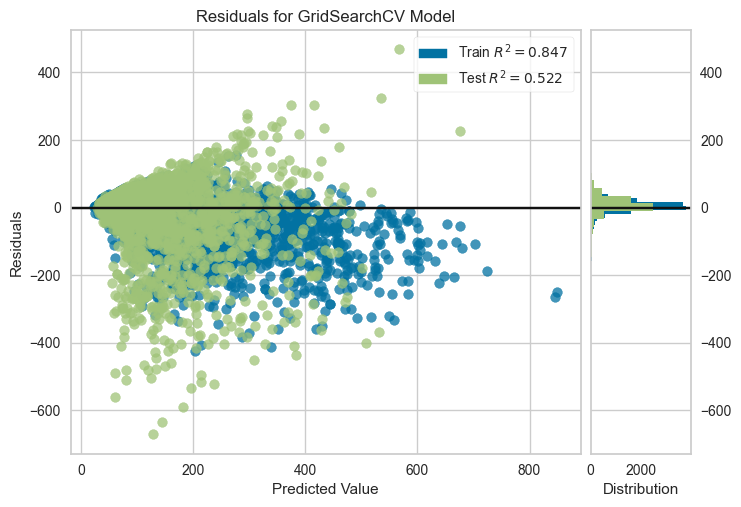

<AxesSubplot: title={'center': 'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [22]:
from yellowbrick.regressor import ResidualsPlot
visualiser = ResidualsPlot(xgb_Grid)
visualiser.fit(X_train_std, y_train)
visualiser.score(X_test_std, y_test)
visualiser.poof()

In [25]:
import time
start = time.time()
grid_model.fit(X_train_std, y_train)
y_pred = grid_model.predict(X_test_std)
stop = time.time()
Execution_time = (stop - start)
print("Execution time: {:.2f} seconds".format(Execution_time))

Execution time: 0.73 seconds
